In [2]:
import math,os,random,cv2,numpy as np,torch
import torch.nn as nn


# C3K2

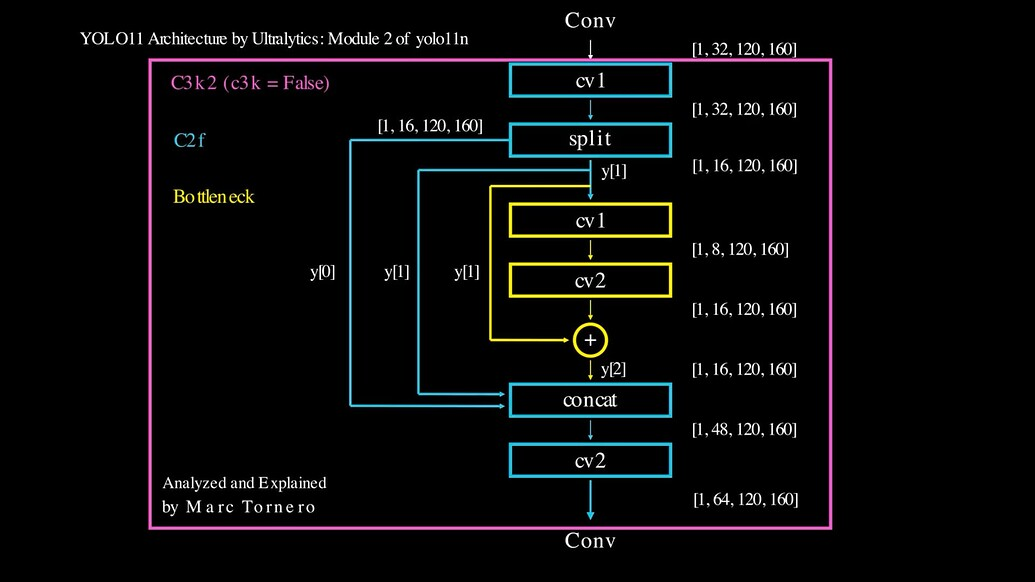

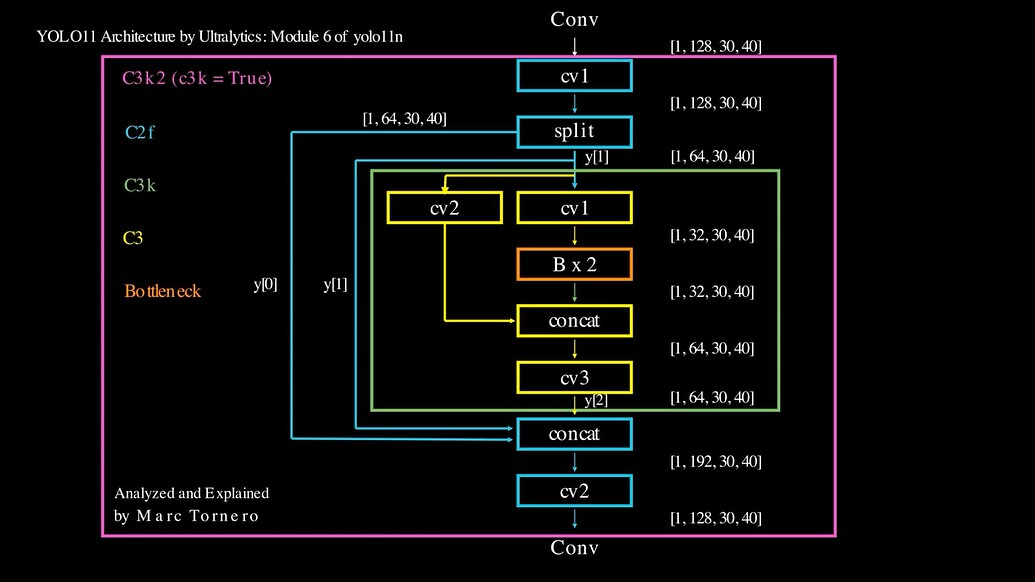

<img src="../Images/yolov11_layers.png" alt="YOLOv11 layers" width="400px" />


In [5]:
from model_classes import Conv
class c3k2_Bottleneck(nn.Module):
    def __init__(self,in_channels,out_channels, shortcut = True, g=1, k=(3, 3), e=0.5):
        super().__init__()
        hidden_channels = int(out_channels * e)  # hidden channels
        self.conv1 = Conv(in_channels,hidden_channels,kernel_size=3,stride=1,padding=1)
        self.conv2 = Conv(hidden_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.shortcut = shortcut

    def forward(self, x):
        x_in = x # for residual connection
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut:
            x=x+x_in
        return x


class c3k2_c2f(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottleneck, shortcut=True, g=1, e=0.5):
        super().__init__()
        self.hidden_channels = int(out_channels*e)
        self.num_bottleneck = num_bottleneck
        self.conv1 = Conv(in_channels,2*self.hidden_channels,kernel_size=1,stride=1,padding=0)
        self.conv2 = Conv((num_bottleneck+2)*self.hidden_channels, out_channels,kernel_size=1,stride=1,padding=0)
        self.m = nn.ModuleList([c3k2_Bottleneck(self.hidden_channels, self.hidden_channels, k=((3, 3), (3, 3)), e=1.0) for _ in range(num_bottleneck)])
    
    def forward(self, x):

        x = self.conv1(x)
        outputs = list(x.chunk(2, 1)) # splitting the channels into two parts, output = [x0, x1]
        outputs.extend(m(outputs[-1]) for m in self.m) # bottleneck added in last, outputs = [x0, x1, bottleneck1, ..., bottleneckN]
        outputs = torch.cat(outputs,dim=1) # dim = [B, (2 + num_bottleneck) * (out_channels // 2), H, W]
        out = self.conv2(outputs) # dim = [B, out_channels, H, W]

        return out
    
class C3K2(c3k2_c2f):
    
    def __init__(self, in_channels,out_channels, num_bottleneck=1, c3k=False, e=0.5, g=1, shortcut = True):
        super().__init__(in_channels, out_channels, num_bottleneck, shortcut, g, e)
        self.m = nn.ModuleList(
            C3K(self.hidden_channels, self.hidden_channels, 2, shortcut=shortcut, g=g) if c3k 
            else c3k2_Bottleneck(self.hidden_channels, self.hidden_channels, shortcut=shortcut, g=g)
            for _ in range(num_bottleneck)
        )
        

class C3K(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottleneck=1, shortcut = True, g=1, e=0.5, k=3):
        super().__init__()
        hidden_channels = int(out_channels*e)
        self.cv1 = Conv(in_channels, hidden_channels, kernel_size=1, stride=1)
        self.cv2 = Conv(in_channels, hidden_channels, kernel_size=1, stride=1)
        self.cv3 = Conv(2*hidden_channels, out_channels, kernel_size=1, stride=1)
        self.m = nn.Sequential(*(c3k2_Bottleneck(hidden_channels, hidden_channels, shortcut=shortcut, g=g, k=(k,k), e=1.0) for _ in range(num_bottleneck)))

    def forward(self, x):
        """Forward pass through the C3k bottleneck with 2 convolutions."""
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))
        
        

In [6]:
# sanity check
c3k2 = C3K2(in_channels=64,out_channels=128,num_bottleneck=3)
print(f"{sum(p.numel() for p in c3k2.parameters())/1e6} million parameters")

dummy_input = torch.rand((1,64,244,244))
dummy_output = c3k2(dummy_input)
print("Output shape: ",dummy_output.shape)

0.160832 million parameters
Output shape:  torch.Size([1, 128, 244, 244])


In [3]:
def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p
class Conv(nn.Module):
    default_act = nn.SiLU()  # default activation
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = None, g = 1,d=1, act = True):
        super().__init__()
        # self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias = False,groups = g)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, autopad(kernel_size, padding, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(out_channels,eps = 0.001,momentum=0.03)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self,x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class C2PSA(nn.Module):
    """
    This module implements a convolutional block with attention mechanisms to enhance feature extraction and processing
    capabilities. It includes a series of PSABlock modules for self-attention and feed-forward operations.
    """

    def __init__(self, c1, c2, n=1, e=0.5):
        """Initializes the C2PSA module with specified input/output channels, number of layers, and expansion ratio."""
        super().__init__()
        assert c1 == c2
        self.c = int(c1 * e)
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv(2 * self.c, c1, 1)

        self.m = nn.Sequential(*(PSABlock(self.c, attn_ratio=0.5, num_heads=self.c // 64) for _ in range(n)))

    def forward(self, x):
        """Processes the input tensor 'x' through a series of PSA blocks and returns the transformed tensor."""
        a, b = self.cv1(x).split((self.c, self.c), dim=1)
        b = self.m(b)
        return self.cv2(torch.cat((a, b), 1))

class Attention(nn.Module):
    """
    Attention module that performs self-attention on the input tensor.

    Args:
        dim (int): The input tensor dimension.
        num_heads (int): The number of attention heads.
        attn_ratio (float): The ratio of the attention key dimension to the head dimension.

    Attributes:
        num_heads (int): The number of attention heads.
        head_dim (int): The dimension of each attention head.
        key_dim (int): The dimension of the attention key.
        scale (float): The scaling factor for the attention scores.
        qkv (Conv): Convolutional layer for computing the query, key, and value.
        proj (Conv): Convolutional layer for projecting the attended values.
        pe (Conv): Convolutional layer for positional encoding.
    """

    def __init__(self, dim, num_heads=8, attn_ratio=0.5):
        """Initializes multi-head attention module with query, key, and value convolutions and positional encoding."""
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.key_dim = int(self.head_dim * attn_ratio)
        self.scale = self.key_dim**-0.5
        nh_kd = self.key_dim * num_heads
        h = dim + nh_kd * 2
        self.qkv = Conv(dim, h, 1, act=False)
        self.proj = Conv(dim, dim, 1, act=False)
        self.pe = Conv(dim, dim, 3, 1, g=dim, act=False)
        # self.qkv = Conv(dim, h, 1, activation=False)
        # self.proj = Conv(dim, dim, 1, activation= False)
        # self.pe = Conv(dim, dim, 3, 1, groups=dim, activation= False)

    def forward(self, x):
        """
        Forward pass of the Attention module.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            (torch.Tensor): The output tensor after self-attention.
        """
        B, C, H, W = x.shape
        N = H * W
        # qkv = self.qkv(x)
        # q, k, v = qkv.view(B, self.num_heads, self.key_dim * 2 + self.head_dim, N).split(
        #     [self.key_dim, self.key_dim, self.head_dim], dim=2
        # )
        qkv = self.qkv(x)              # [B, h, H, W]
        qkv = qkv.flatten(2)           # [B, h, N]
        qkv = qkv.reshape(B, self.num_heads, 2*self.key_dim + self.head_dim, N)
        q, k, v = qkv.split([self.key_dim, self.key_dim, self.head_dim], dim=2)

        attn = (q.transpose(-2, -1) @ k) * self.scale
        attn = attn.softmax(dim=-1)
        x = (v @ attn.transpose(-2, -1)).view(B, C, H, W) + self.pe(v.reshape(B, C, H, W))
        x = self.proj(x)
        return x

class PSABlock(nn.Module):
    """
    This class encapsulates the functionality for applying multi-head attention and feed-forward neural network layers with optional shortcut connections.
    """

    def __init__(self, c, attn_ratio=0.5, num_heads=4, shortcut=True) -> None:
        """Initializes the PSABlock with attention and feed-forward layers for enhanced feature extraction."""
        super().__init__()

        self.attn = Attention(c, attn_ratio=attn_ratio, num_heads=num_heads)
        # self.ffn = nn.Sequential(Conv(c, c * 2, 1), Conv(c * 2, c, 1, activation=False))
        self.ffn = nn.Sequential(Conv(c, c * 2, 1), Conv(c * 2, c, 1, act=False))
        self.add = shortcut

    def forward(self, x):
        """Executes a forward pass through PSABlock, applying attention and feed-forward layers to the input tensor."""
        x = x + self.attn(x) if self.add else self.attn(x)
        x = x + self.ffn(x) if self.add else self.ffn(x)
        return x

In [ ]:
# sanity check
c2psa = C2PSA(128,128)
print(f"{sum(p.numel() for p in c2psa.parameters())/1e6} million parameters")

dummy_input = torch.rand((1,128,244,244))
dummy_output = c2psa(dummy_input)
print("Output shape: ",dummy_output.shape)

0.063424 million parameters
